In [1]:
!pip install nd2
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 16.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nd2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure, io
from skimage.morphology import disk, remove_small_objects

nd2_file_path = '/content/drive/MyDrive/nukedimages/Sample 1A_B4.nd2'

In [ ]:
with nd2.ND2File(nd2_file_path) as f:
    # Print metadata or sizes to understand the dimensions.
    # f.sizes is a dictionary that might include keys like 'c' (channels), 'z', 'y', 'x'
    print("ND2 file sizes:", f.sizes)

    # Load the full image data into a NumPy array.
    # NOTE: Depending on the file, the array shape could be e.g. (channels, z, y, x)
    image_array = f.asarray()

print("Image array shape:", image_array.shape)

ND2 file sizes: {'Z': 5, 'C': 2, 'Y': 6104, 'X': 6104}
Image array shape: (5, 2, 6104, 6104)


In [ ]:
# ---------------------------------------------
# 2. Select a channel and perform a z-projection
# ---------------------------------------------
# For example, if the array shape is (channels, z, y, x) and nuclei are in channel 0:
channel_index = 0
# Adjust the slicing if your dimension order is different.
img_channel = image_array[:,channel_index, :, :]

# Perform a z-projection.
# You might use maximum intensity (commonly used for fluorescence images).
proj_img = np.max(img_channel, axis=0)

In [ ]:
# ---------------------------------------------
# 3. Adjust contrast
# ---------------------------------------------
# Rescale intensities to span the full range (0 to 255, for example)
img_adjusted = exposure.rescale_intensity(proj_img)

# ---------------------------------------------
# 4. Threshold using Otsu's method
# ---------------------------------------------
thresh_value = filters.threshold_otsu(img_adjusted)
binary_mask = img_adjusted > thresh_value

In [ ]:
# ---------------------------------------------
# 5. Morphological operations: dilate then erode
# ---------------------------------------------
# Define a structuring element; here we use a small disk.
selem = disk(1)
mask_dilated = morphology.binary_dilation(binary_mask, selem)
mask_eroded = morphology.binary_erosion(mask_dilated, selem)

# ---------------------------------------------
# 6. Remove small objects (particle filtering)
# ---------------------------------------------
# Remove objects smaller than 10 pixels.
mask_filtered = remove_small_objects(mask_eroded, min_size=10)

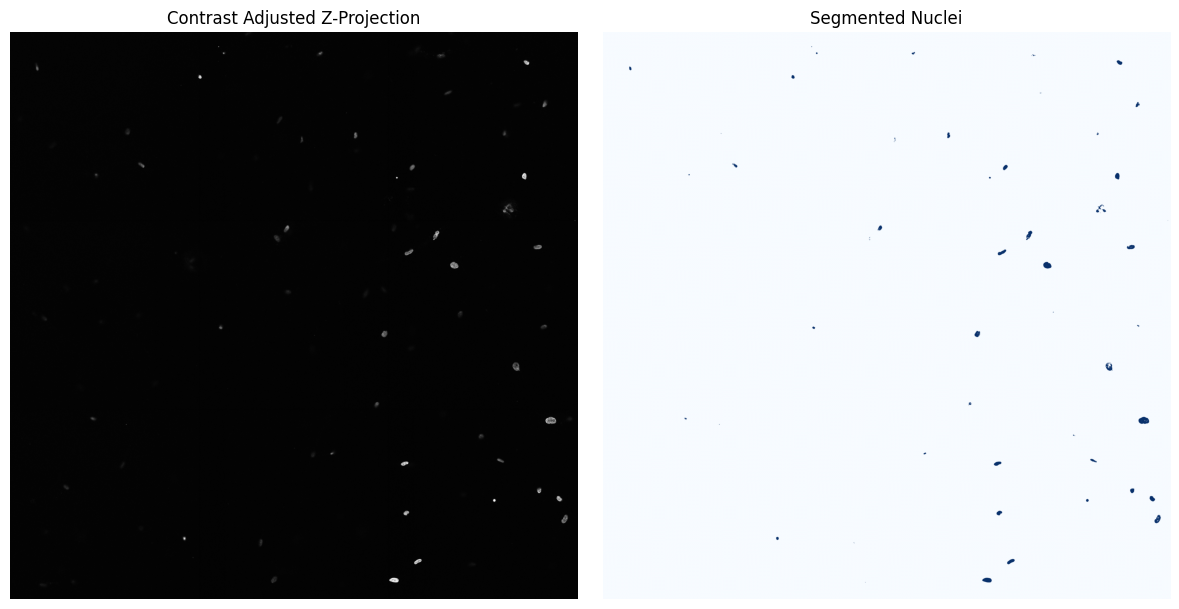

In [ ]:
# ---------------------------------------------
# 7. Visualize the results
# ---------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Show the contrast-adjusted projection.
axes[0].imshow(img_adjusted, cmap='gray')
axes[0].set_title('Contrast Adjusted Z-Projection')
axes[0].axis('off')

# Show the final segmentation mask.
axes[1].imshow(mask_filtered, cmap='Blues')
axes[1].set_title('Segmented Nuclei')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------------
# 8. Save the segmentation as a TIFF file
# ---------------------------------------------
# Convert the boolean mask to uint8 (0 and 255) so it saves nicely as an image.
mask_to_save = (mask_filtered.astype(np.uint8)) * 255
output_path = 'segmented_nuclei.tif'
io.imsave(output_path, mask_to_save)

print(f"Segmentation saved as {output_path}")

Segmentation saved as segmented_nuclei.tif


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmented_nuclei.tif is a low contrast image
  return func(*args, **kwargs)


**METHOD 2**

NOTES:

We loop through all 5 z-planes (using range(nd2_images.sizes['z'])) for channel 0.
A maximum intensity projection is performed using np.max(frames, axis=0) so that your projection resembles the ImageJ “change z projection” step.
Contrast Adjustment:

We apply exposure.rescale_intensity with in_range=(0,1797) (matching your ImageJ B&C settings) and map to (0,255).
Segmentation Workflow:

Otsu’s thresholding is applied.
A dilation followed by erosion (similar to a closing operation) is performed.
Small objects (less than 10 pixels) are removed using remove_small_objects.
Visualization and Saving:

Two side‐by‐side plots display the contrast-adjusted projection and the final segmentation mask.
Finally, the mask is saved as a TIFF file after converting from boolean to a uint8 image (multiplying by 255).

In [7]:
!pip install nd2reader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84591 sha256=85763d5b08a348b295a2f761916d9f3ad628dd91f5f42c887cd9491f33296ef7
  Stored in directory: /root/.cache/pip/wheels/19/dc/d2/e872d34a5e460ff64d2f916938044498fc123855a68318b9d5
Successfully built pims


Changes:
Z-Projection Fix – Explicitly loops over z slices to create a max projection.
Contrast Adjustment – Uses exposure.rescale_intensity with ImageJ B&C values (0-1797 → 0-255).
Bug Prevention – Ensures ND2 indices are handled correctly (c, z).

ND2 sizes: {'x': 6104, 'y': 6104, 'c': 2, 't': 1, 'z': 5}


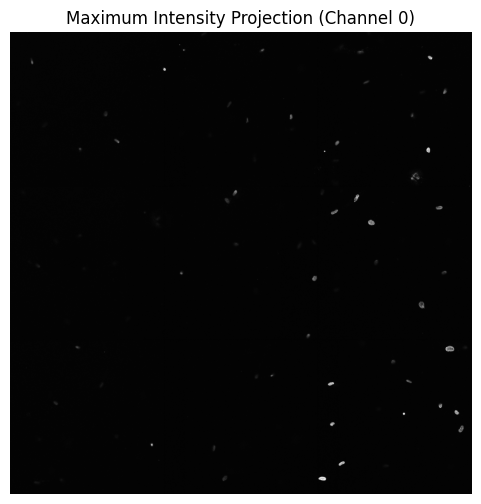

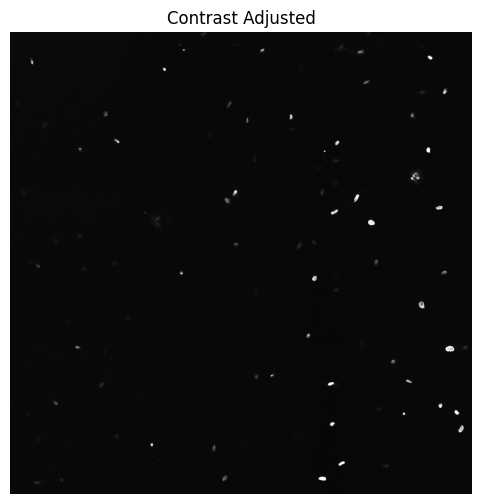

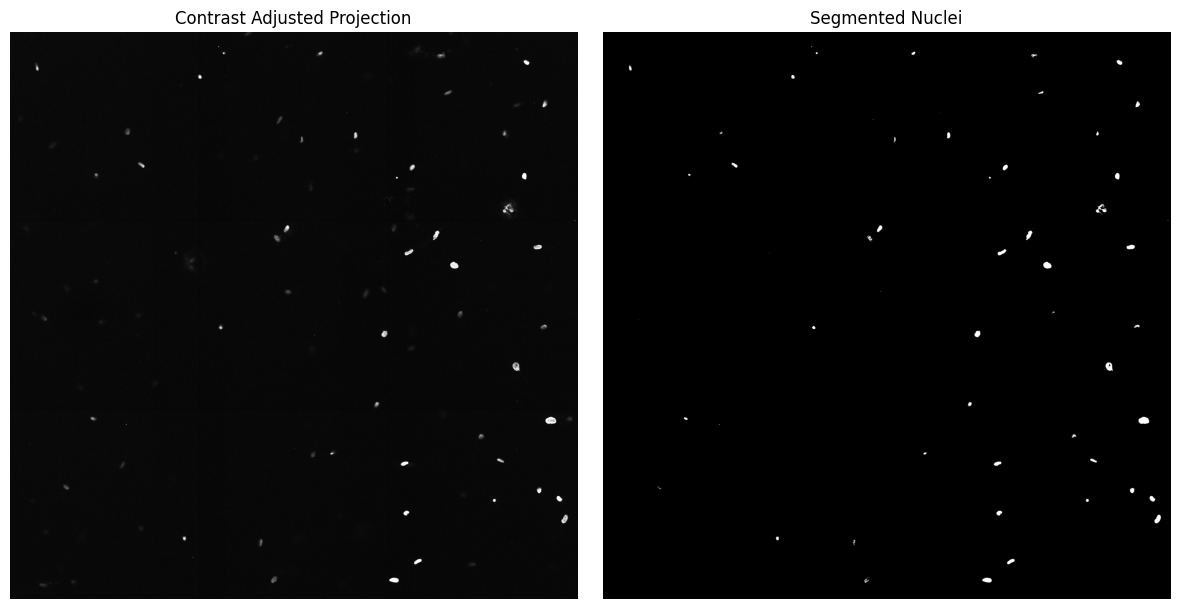

Segmentation saved as segmented_nuclei.tif


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmented_nuclei.tif is a low contrast image
  return func(*args, **kwargs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
from skimage import exposure, filters, morphology, io
from skimage.morphology import disk, remove_small_objects

# =============================================
# 1. Load the ND2 file and examine dimensions
# =============================================
nd2_file_path = "/content/drive/MyDrive/nukedimages/Sample 1A_B4.nd2"
nd2_images = ND2Reader(nd2_file_path)
print("ND2 sizes:", nd2_images.sizes)
# Expected output (for example): {'x': 6104, 'y': 6104, 'c': 2, 't': 1, 'z': 5}

# =============================================
# 2. Z-Projection on the Selected Channel
# =============================================
# Choose the channel you want (here we choose channel 0)
c_index = 0

# Collect all z-planes for this channel
frames = []
for z in range(nd2_images.sizes['z']):
    frame = nd2_images.get_frame_2D(c=c_index, z=z)
    frames.append(frame)
frames = np.array(frames)

# Perform maximum intensity projection over the z-axis
proj_img = np.max(frames, axis=0)

# Visualize the projection
plt.figure(figsize=(6,6))
plt.imshow(proj_img, cmap='gray')
plt.title("Maximum Intensity Projection (Channel 0)")
plt.axis("off")
plt.show()

# =============================================
# 3. Adjust Contrast (ImageJ B&C: 0 to 1797)
# =============================================
# These values come from your ImageJ contrast settings.
min_intensity = 0
max_intensity = 1797

# Rescale intensities: map the input range (0,1797) to (0,255)
img_adjusted = exposure.rescale_intensity(proj_img, in_range=(min_intensity, max_intensity), out_range=(0,255))

# Visualize the contrast-adjusted image
plt.figure(figsize=(6,6))
plt.imshow(img_adjusted, cmap='gray')
plt.title("Contrast Adjusted")
plt.axis("off")
plt.show()

# =============================================
# 4. Threshold Using Otsu's Method
# =============================================
thresh_value = filters.threshold_otsu(img_adjusted)
binary_mask = img_adjusted > thresh_value

# =============================================
# 5. Morphological Operations: Dilate then Erode
# =============================================
# Use a small disk as the structuring element
selem = disk(1)
mask_dilated = morphology.binary_dilation(binary_mask, selem)
mask_eroded = morphology.binary_erosion(mask_dilated, selem)

# =============================================
# 6. Remove Small Objects (Particle Filtering)
# =============================================
# Remove objects smaller than 10 pixels
mask_filtered = remove_small_objects(mask_eroded, min_size=10)

# =============================================
# 7. Visualize the Results
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Left: contrast-adjusted projection image
axes[0].imshow(img_adjusted, cmap='gray')
axes[0].set_title('Contrast Adjusted Projection')
axes[0].axis('off')
# Right: final segmentation mask
axes[1].imshow(mask_filtered, cmap='gray')
axes[1].set_title('Segmented Nuclei')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# =============================================
# 8. Save the Segmentation as a TIFF File
# =============================================
# Convert the boolean mask to uint8 (0 and 255) for saving
mask_to_save = (mask_filtered.astype(np.uint8)) * 255
output_path = 'segmented_nuclei.tif'
io.imsave(output_path, mask_to_save)
print(f"Segmentation saved as {output_path}")

Pipeline Seg

In [ ]:
import os
import numpy as np
from skimage import io, exposure, filters, morphology
from skimage.morphology import disk, remove_small_objects
import matplotlib.pyplot as plt
from nd2reader import ND2Reader

def process_nd2_image(nd2_path, output_folder, selem_size=1, min_particle_size=10):
    # Load ND2 file
    with ND2Reader(nd2_path) as nd2_images:
        nd2_images.iter_axes = 'z'  # Ensure we iterate over Z-axis
        nd2_images.bundle_axes = 'yx'  # Keep spatial dimensions

        # Max projection across Z slices
        proj_img = np.max(np.array([frame for frame in nd2_images]), axis=0)

        min_intensity = 0
        max_intensity = 1797

        # Rescale intensities: map the input range (0,1797) to (0,255)
        img_adjusted = exposure.rescale_intensity(proj_img, in_range=(min_intensity, max_intensity), out_range=(0,255))

        # Thresholding
        thresh_value = filters.threshold_otsu(img_adjusted)
        binary_mask = img_adjusted > thresh_value

        # Morphological operations
        selem = disk(selem_size)
        mask_dilated = morphology.binary_dilation(binary_mask, selem)
        mask_eroded = morphology.binary_erosion(mask_dilated, selem)

        # Particle filtering
        mask_filtered = remove_small_objects(mask_eroded, min_size=min_particle_size)

        # Save result
        output_path = os.path.join(output_folder, os.path.basename(nd2_path).replace('.nd2', '_segmented.tif'))
        io.imsave(output_path, (mask_filtered.astype(np.uint8) * 255))

        print(f"Processed: {nd2_path} -> {output_path}")

# Example: Run for all ND2 files in a folder
input_folder = "/content/drive/MyDrive/images2/"
output_folder = "/content/drive/MyDrive/segmented_nucleus_images/"

os.makedirs(output_folder, exist_ok=True)
nd2_files = [f for f in os.listdir(input_folder) if f.endswith('.nd2')]

for file in nd2_files:
    process_nd2_image(os.path.join(input_folder, file), output_folder)

Processed: /content/drive/MyDrive/images2/008_G10.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/008_G10_segmented.tif
Processed: /content/drive/MyDrive/images2/009_G11.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/009_G11_segmented.tif
Processed: /content/drive/MyDrive/images2/011_G13.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/011_G13_segmented.tif
Processed: /content/drive/MyDrive/images2/012_G14.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/012_G14_segmented.tif
Processed: /content/drive/MyDrive/images2/013_G15.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/013_G15_segmented.tif
Processed: /content/drive/MyDrive/images2/014_G16.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/014_G16_segmented.tif
Processed: /content/drive/MyDrive/images2/015_G17.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/015_G17_segmented.tif
Processed: /content/drive/MyDrive/images2/017_G19.nd2 -> /content/drive/MyDrive/segmented_nucleus_images/017_G1

**Get the Raw Images:**

In [14]:
import numpy as np
from skimage import io
from nd2reader import ND2Reader

def extract_raw_image(nd2_path, raw_output_folder):
    with ND2Reader(nd2_path) as nd2_images:
        nd2_images.iter_axes = 'z'
        nd2_images.bundle_axes = 'yx'

        # Max projection across Z slices
        proj_img = np.max(np.array([frame for frame in nd2_images]), axis=0)

        # Print min/max values for debugging
        print(f"Processing {os.path.basename(nd2_path)}")
        print("Min Pixel Value:", proj_img.min())
        print("Max Pixel Value:", proj_img.max())

        # Save raw image as 16-bit TIFF (if values are in range 0-65535)
        raw_output_path = os.path.join(raw_output_folder, os.path.basename(nd2_path).replace('.nd2', '_raw.tif'))
        io.imsave(raw_output_path, (mask_filtered.astype(np.uint8) * 255))
        print(f"Saved raw image: {raw_output_path}")

# Define folders
input_folder = "/content/drive/MyDrive/images2/"
raw_output_folder = "/content/drive/MyDrive/raw_images/"

# Create output folder if it doesn't exist
os.makedirs(raw_output_folder, exist_ok=True)

# Process all ND2 files in the input folder
nd2_files = [f for f in os.listdir(input_folder) if f.endswith('.nd2')]

for file in nd2_files:
    extract_raw_image(os.path.join(input_folder, file), raw_output_folder)

Processing 008_G10.nd2
Min Pixel Value: 0
Max Pixel Value: 4095


NameError: name 'mask_filtered' is not defined

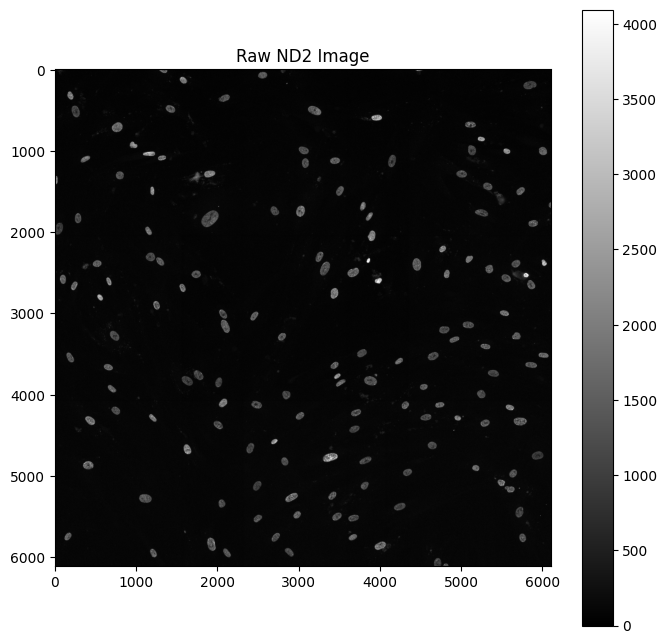

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from nd2reader import ND2Reader

# Path to a single ND2 file (Change this to an actual file in your folder)
nd2_path = "/content/drive/MyDrive/images2/008_G10.nd2"

# Load and extract the raw image
with ND2Reader(nd2_path) as nd2_images:
    nd2_images.iter_axes = 'z'  # Ensure iteration over Z-axis
    nd2_images.bundle_axes = 'yx'  # Keep spatial dimensions

    # Max projection across Z slices
    proj_img = np.max(np.array([frame for frame in nd2_images]), axis=0)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(proj_img, cmap="gray")
    plt.colorbar()
    plt.title("Raw ND2 Image")
    plt.show()

FINAL PIPELINE FOR RAW AND SEGMENTED IMAGES

In [18]:
import os
import numpy as np
from skimage import io, exposure, filters, morphology
from skimage.morphology import disk, remove_small_objects
from nd2reader import ND2Reader

def process_nd2_image(nd2_path, raw_output_folder, seg_output_folder, selem_size=1, min_particle_size=10):
    # Load ND2 file
    with ND2Reader(nd2_path) as nd2_images:
        nd2_images.iter_axes = 'z'  # Iterate over Z-axis
        nd2_images.bundle_axes = 'yx'  # Keep spatial dimensions

        # Max projection across Z slices
        proj_img = np.max(np.array([frame for frame in nd2_images]), axis=0)

        ### ✅ FIXED: Rescale to 16-bit Properly ###
        min_intensity = 0
        max_intensity = 1797  # Your max detected value

        proj_img_scaled = exposure.rescale_intensity(proj_img, in_range=(min_intensity, max_intensity), out_range=(0, 65535))

        # Convert to 16-bit and save
        raw_output_path = os.path.join(raw_output_folder, os.path.basename(nd2_path).replace('.nd2', '_raw.tif'))
        io.imsave(raw_output_path, proj_img_scaled.astype(np.uint16))

        ### 🔥 SEGMENTATION PROCESS (Unchanged) ###
        img_adjusted = exposure.rescale_intensity(proj_img, in_range=(min_intensity, max_intensity), out_range=(0, 255))
        thresh_value = filters.threshold_otsu(img_adjusted)
        binary_mask = img_adjusted > thresh_value

        # Morphology
        selem = disk(selem_size)
        mask_dilated = morphology.binary_dilation(binary_mask, selem)
        mask_eroded = morphology.binary_erosion(mask_dilated, selem)
        mask_filtered = remove_small_objects(mask_eroded, min_size=min_particle_size)

        # Save segmented image
        seg_output_path = os.path.join(seg_output_folder, os.path.basename(nd2_path).replace('.nd2', '_segmented.tif'))
        io.imsave(seg_output_path, (mask_filtered.astype(np.uint8) * 255))

        print(f"✅ SAVED: {raw_output_path} (RAW) | {seg_output_path} (SEGMENTED)")

# Define folders
input_folder = "/content/drive/MyDrive/images2/"
raw_output_folder = "/content/drive/MyDrive/raw_images/"
seg_output_folder = "/content/drive/MyDrive/new_segmented_nucleus_images/"

os.makedirs(raw_output_folder, exist_ok=True)
os.makedirs(seg_output_folder, exist_ok=True)

# Process all ND2 files
nd2_files = [f for f in os.listdir(input_folder) if f.endswith('.nd2')]

for file in nd2_files:
    process_nd2_image(os.path.join(input_folder, file), raw_output_folder, seg_output_folder)

✅ SAVED: /content/drive/MyDrive/raw_images/008_G10_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/008_G10_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/009_G11_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/009_G11_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/011_G13_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/011_G13_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/012_G14_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/012_G14_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/013_G15_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/013_G15_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/014_G16_raw.tif (RAW) | /content/drive/MyDrive/new_segmented_nucleus_images/014_G16_segmented.tif (SEGMENTED)
✅ SAVED: /content/drive/MyDrive/raw_images/015_G17_raw.tif (RAW) | /content/drive/